# Shallow Water Bathymetry With ICESat-2

Tutorial led by Jonathan Markel at the 2023 ICESat-2 Hackweek.

## Learning Objectives
- Learn what ICESat-2 bathymetry looks like, where to find it, and how to visualize it
- Understand pros / cons of different signal finding approaches for bathymetry
- Extract water surface and seafloor returns from the photon data
- Apply refraction correction to subsurface photon heights

## Prerequisites
- EarthData Account
- [SlideRule](https://slideruleearth.io/web/)
- ATL03 photon heights (See User Guide available [here](https://nsidc.org/data/atl03/versions/6) via NSIDC)

# Introduction

ICESat-2 is a spaceborne laser altimeter launched by NASA in 2018 to collect ice sheet, cloud, and land elevation data. It has also demonstrated the ability to collect shallow water depths, AKA 'bathymetry', in many coastal locations around the world. Until the release of [ATL24](https://ui.adsabs.harvard.edu/abs/2022AGUFM.C35D0907M/abstract) simplifies the task of analyzing ICESat-2 derived depth data for most users, some may be interested in using the ATL03 data to analyze their own area of interest. Several different methods have been developed in the literature for classifying bathymetry photons, including density-based, histogram-based, and other approaches, often requiring some level of manual intervention to account for different shallow water environments.

This tutorial aims to develop the basic Python data access, analysis, and visualization techniques for anyone to get started using ICESat-2 for shallow water bathymetry around the world.


Let's import the Python packages needed for this tutorial and initialize Sliderule for downloading the data.

In [1]:
import os
import scipy
import skimage
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from tqdm import tqdm
import shapely
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


from sliderule import sliderule, icesat2, earthdata

import ipyleaflet
from datetime import datetime, timedelta
from shapely import Polygon

In [2]:
# %pip install --quiet "sliderule>=4.6"

In [3]:
url = "slideruleearth.io"
sliderule.init(url, verbose=False)
asset = "icesat2"

# Define Study Site

For the purposes of this demo, we'll use OpenAltimetry to identify an ICESat-2 track with good bathymetric signal for analysis.
1. Go to [OpenAltimetry's ICESat-2 Webpage](https://openaltimetry.org/data/icesat2/), and navigate to your general area of interest.
2. Select a ground track / date, try a few dates to see how the ground track / signal varies between satellite overpasses.
3. Use the ATL08 preview (default) to identify tracks that are likely to have a good signal. A track with good signal will have dense, regularly space points appear over the satellite ground track.
4. Draw a bounding box using the 'Select a Region' button in the top left. Click on this box and 'View Signal Photons'.
5. Let's make sure we're actually looking at the photon data we're interested in. Select 'View All Data' (available for small to medium sized AOIs) to ensure all photons are plotted. Without this step bathymetry signal is often hidden by its relatively low density. You may also need to adjust which signal photons are plotted using the buttons below the figure.
6. If the track contains good bathymetric signal, note the date and track ID (repeat ground track number) below.

Alternatively, one of several areas of interest can be selected by modifying the 'aoi_name' variable in the next cell, just in case there are issues accessing EarthData or finding data in OpenAltimetry during the demo.

In [4]:
# modify the following lines for custom tracks identified from Open Altimetry

target_date = '' #'YYYY-MM-DD'
target_rgt = 0 # track ID

In [5]:
# set aoi_name to user defined if date/rgt specified using OpenAltimetry

aoi_name = 'new_zealand' # options: user_defined, new_zealand, japan, north_carolina, eritrea, bahamas

aoi_data = {
    'user_defined': {
        'target_date': target_date,
        'target_rgt': target_rgt,
        'bbox_coords': [],
    },
    'new_zealand': {
        'target_date': '2022-07-05',
        'target_rgt': 214,
        'bbox_coords': [[[172.66, -40.63],
                         [172.66, -40.47],
                         [173.14, -40.47],
                         [173.14, -40.63],
                         [172.66, -40.63]]]
    },
    'japan': {
        'target_date': '2021-10-30',
        'target_rgt': 582,
        'bbox_coords': [[[127.67, 26.16],
                         [127.67, 26.77],
                         [128.24, 26.77],
                         [128.24, 26.16],
                         [127.67, 26.16]]]
    },
    'north_carolina': {
        'target_date': '2022-06-26',
        'target_rgt': 65,
        'bbox_coords': [[[-75.87, 34.82],
                         [-75.87, 36.17],
                         [-75.19, 36.17],
                         [-75.19, 34.82],
                         [-75.87, 34.82]]]
    },
    'eritrea': {
        'target_date': '2022-09-19',
        'target_rgt': 1363,
        'bbox_coords': [[[39.90, 15.47],
                         [39.90, 16.10],
                         [40.53, 16.10],
                         [40.53, 15.47],
                         [39.90, 15.47]]]
    },
    'bahamas': {
        'target_date': '2021-07-09',
        'target_rgt': 248,
        'bbox_coords': [[[-76.8, 23.27],
                          [-76.8, 23.84],
                          [-76.22, 23.84],
                          [-76.22, 23.27],
                          [-76.8, 23.27]]]
    }
}

try:
    aoi_info = aoi_data[aoi_name]
    target_date = aoi_info['target_date']
    target_rgt = aoi_info['target_rgt']
    bbox_coords = aoi_info['bbox_coords']
    
except KeyError:
    raise RuntimeError("Invalid AOI name")


We've specified a date and ground track for our data, but many ICESat-2 passes are larger than the actual study site. So lets specify a bounding box on the map below to use when querying data to reduce the overall data quantity. If using one of the preselected AOI's, it will be shown automatically. If not, use the polygon or box drawing tools to make your own! Results are automatically saved. If you need to start over with your polygon, just rerun the cell below. It's also recommended to ensure your bounding box is primarily over water for bathymetric analysis.

In [6]:
# function to store any bounds drawn by the user
def handle_draw(target, action, geo_json):
    if action == 'created':
        coords = geo_json['geometry']['coordinates'][0]
        bbox_coords.append(coords)

def reverse_coordinates(bbox_coords):
    reversed_coords = []
    
    for box in bbox_coords:
        reversed_box = []
        for point in box:
            reversed_box.append([point[1], point[0]])
        reversed_coords.append(reversed_box)
    
    return reversed_coords

# setting up the map
m = ipyleaflet.Map(basemap=ipyleaflet.basemaps.Esri.WorldImagery, 
        center=(0, 0), 
        zoom=3, 
        scroll_wheel_zoom=True)

# simplifying user options - can be used to enable polygons, line drawings, etc
dc = ipyleaflet.DrawControl(circlemarker={}, polyline={})

# defining bounding box/polygon properties
custom_shape_options = {
        "fillColor": "red",
        "color": "red",
        "fillOpacity": 0.5
    }

dc.rectangle = {"shapeOptions": custom_shape_options}
dc.polygon = {"shapeOptions": custom_shape_options}

# add pre-existing bounding box to map if it exists
if aoi_name == 'user_defined':
    bbox_coords = []
    print('Draw bounding box on map below...')

else:
    poly_gdf = gpd.GeoDataFrame(geometry=[Polygon(bbox_coords[0])],
                                crs="EPSG:4326")

    m.center=(poly_gdf.geometry[0].centroid.y, poly_gdf.geometry[0].centroid.x)
    m.zoom = 8

    poly_map = ipyleaflet.Polygon(
        locations=reverse_coordinates(bbox_coords),
        color="red",
        fill_color="red"
    )

    m.add_layer(poly_map);
    
dc.on_draw(handle_draw)
m.add_control(dc)

m

Map(center=[-40.54999999999999, 172.89999999999998], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [7]:
# Print the extracted information
print('AOI Name:', aoi_name.upper())
print("Target Date:", target_date)
print("Target RGT:", target_rgt)
print("Bounding Box Coordinates:\n", np.round(bbox_coords, 2))

AOI Name: NEW_ZEALAND
Target Date: 2022-07-05
Target RGT: 214
Bounding Box Coordinates:
 [[[172.66 -40.63]
  [172.66 -40.47]
  [173.14 -40.47]
  [173.14 -40.63]
  [172.66 -40.63]]]


In [8]:
# use the middle, strong beam for this demo
# for more on this, see the ATL03 user guide, or other hackweek documentation
beam_type = 'strong'
track_num = 2

# Downloading ICESat-2 Data

Now that we've specified a bounding box, date, and ground track, we can use Sliderule to download the photon data. Note that we are also specially requesting additional fields from the ATL03 data needed for bathymetric analysis (e.g., ref_azimuth). The data dictionary, which contains details of all available fields is available via NSIDC [(link to PDF)](https://nsidc.org/sites/default/files/documents/technical-reference/icesat2_atl03_data_dict_v006.pdf).

Note that there are a many ways to access photon data - using EarthData, OpenAltimetry, NSIDC, icepyx, etc... the best really depends on your use case.

In [14]:
%%time

# Reformatting bounding box for query purposes
coords_arr = np.array(bbox_coords[0]) # use only the first polygon you draw
poly = []

for point in coords_arr:
    poly.append({
        'lat': point[1],
        'lon': point[0]
    })

# sliderule parameters for querying photon data
parms = {
    
    "len": 20,
    "pass_invalid": True, # include segments which dont pass all checks
    "cnf": -2, # returns all photons
    
    #  try other signal confidence scores! SRT_LAND, SRT_OCEAN, SRT_SEA_ICE, SRT_LAND_ICE, SRT_INLAND_WATER
    "srt": icesat2.SRT_LAND, 
    
    # density based signal finding
    "yapc": dict(knn=0, win_h=6, win_x=11, min_ph=4, score=0), 
    
    # extra fields from ATL03 gtxx/geolocation or gtxx/geophys_corr channels
    "atl03_geo_fields": ["ref_azimuth", "ref_elev", "geoid"],
    
    # extra fields via ATL03 "gtxx/heights" (see atl03 data dictionary)
    "atl03_ph_fields": [], # 
    
    # add query polygon
    "poly": poly,

}

# Formatting datetime query for demo purposes - 1 day buffer
day_window = 1 # days on either side to query
target_dt = datetime.strptime(target_date, '%Y-%m-%d')
time_start = target_dt - timedelta(days=day_window)
time_end = target_dt + timedelta(days=day_window)

# find granule for each region of interest
granules_list = earthdata.cmr(short_name='ATL03', 
                              polygon=poly, 
                              time_start=time_start.strftime('%Y-%m-%d'), 
                              time_end=time_end.strftime('%Y-%m-%d'), 
                              version='006')

print(granules_list)

# create an empty geodataframe
df_0 = icesat2.atl03sp(parms, resources=granules_list)

HTTP Request Error: HTTP Error 400: Bad Request
Using simplified polygon (for CMR request only!), 5 points using tolerance of 0.0001


['ATL03_20220704111354_01911613_006_02.h5', 'ATL03_20220705225528_02141609_006_02.h5']
CPU times: user 23.6 s, sys: 549 ms, total: 24.2 s
Wall time: 36.1 s


In [15]:
# confirm that we got extra fields from ATL03 for each photon
print(f'Available photon-rate features: \n{df_0.columns.values}\n')

# inspect photon dataframe
df_0.head()

Available photon-rate features: 
['solar_elevation' 'segment_dist' 'track' 'cycle' 'region' 'sc_orient'
 'background_rate' 'segment_id' 'rgt' 'pair' 'atl08_class' 'y_atc'
 'atl03_cnf' 'snowcover' 'quality_ph' 'height' 'relief' 'yapc_score'
 'landcover' 'x_atc' 'ref_azimuth' 'ref_elev' 'geoid' 'geometry' 'spot']



,solar_elevation,segment_dist,track,cycle,region,sc_orient,background_rate,segment_id,rgt,pair,...,height,relief,yapc_score,landcover,x_atc,ref_azimuth,ref_elev,geoid,geometry,spot
time,,,,,,,,,,,,,,,,,,,,,
2022-07-04 11:16:22.584788736,-66.032097,3.562170e+07,3,16,13,1,1234.506972,1781273,191,1,...,1788.905029,0.0,0,255,3.253127,0.959662,1.566653,17.621201,POINT (172.92468 -40.62883),1
2022-07-04 11:16:22.594088704,-66.032471,3.562176e+07,3,16,13,1,6074.035956,1781276,191,1,...,1865.251343,0.0,0,255,8.989140,0.959447,1.566652,17.621527,POINT (172.92461 -40.62825),1
2022-07-04 11:16:22.626088960,-66.033768,3.562200e+07,3,16,13,1,17805.215193,1781288,191,1,...,1658.077759,0.0,0,255,-3.603853,0.959688,1.566653,17.622810,POINT (172.92435 -40.62621),1
2022-07-04 11:16:22.626188800,-66.033768,3.562200e+07,3,16,13,1,17805.215193,1781288,191,1,...,1647.127563,0.0,0,255,-2.921596,0.959688,1.566653,17.622810,POINT (172.92434 -40.6262),1
2022-07-04 11:16:22.632188672,-66.009857,3.562192e+07,2,16,13,1,71023.552315,1781285,191,1,...,1728.250610,0.0,253,255,8.443647,1.265864,1.559824,17.810932,POINT (172.88596 -40.62962),3


In [18]:
# reducing the total photon data down to a single beam for demonstration purposes
# from the Grand Mesa SlideRule Example

def reduce_dataframe(gdf, RGT=None, GT=None, track=None, pair=None, cycle=None, beam='', crs=4326):
    # convert coordinate reference system
    df = gdf.to_crs(crs)
    
    # reduce to reference ground track
    if RGT is not None:
        df = df[df["rgt"] == RGT]
        
    # reduce to ground track (gt[123][lr]), track ([123]), or pair (l=0, r=1) 
    gtlookup = {icesat2.GT1L: 1, icesat2.GT1R: 1, icesat2.GT2L: 2, icesat2.GT2R: 2, icesat2.GT3L: 3, icesat2.GT3R: 3}
    
    pairlookup = {icesat2.GT1L: 0, icesat2.GT1R: 1, icesat2.GT2L: 0, icesat2.GT2R: 1, icesat2.GT3L: 0, icesat2.GT3R: 1}
    
    if GT is not None:
        df = df[(df["track"] == gtlookup[GT]) & (df["pair"] == pairlookup[GT])]
    if track is not None:
        df = df[df["track"] == track]
    if pair is not None:
        df = df[df["pair"] == pair]
        
    # reduce to weak or strong beams
    # tested on cycle 11, where the strong beam in the pair matches the spacecraft orientation.
    # Need to check on other cycles
    if (beam == 'strong'):
        df = df[df['sc_orient'] == df['pair']]
    elif (beam == 'weak'):
        df = df[df['sc_orient'] != df['pair']]
        
    # reduce to cycle
    if cycle is not None:
        df = df[df["cycle"] == cycle]
        
    # otherwise, return both beams
    return df

df = reduce_dataframe(df_0, 
                      RGT=target_rgt, 
                      track=track_num, 
                      beam=beam_type, 
                      crs='EPSG:4326')

# add a column for along-track distance
df['along_track_meters'] = df['segment_dist']-np.min(df['segment_dist'])

# compute orthometric heights using the onboard geoid model (EGM08)
df['height_ortho'] = df['height'] - df['geoid']

Let's visualize the ICESat-2 overpass on our map to get a better sense of what we're looking at.

In [19]:
# get location of every 100th photon (to reduce data load)
ph_lon = df.geometry.x.values[::100]
ph_lat = df.geometry.y.values[::100]
ph_loc_list = [[y, x] for x, y in zip(ph_lon, ph_lat)]

ground_track = ipyleaflet.Polyline(locations=ph_loc_list, 
                         color='limegreen', weight=5)

m.add_layer(ground_track)

# see map above has been updated with the satellite ground track!

In [20]:
# elevation range for plotting
ylim = [-25, 10]

# filter very shallow / deep data to refine bathymetry
min_bathy_depth = 0.5 
max_bathy_depth = 30

# Visualize Signal 
The ATL03 product and Sliderule provide several built-in measures of photon signal. We've imported the 'Land Confidence' photon signal flag, but this doesn't always capture bathymetry as we'd expect, and is only computed within a certain distance nearshore. We also have a quality flag, which is meant to detect possible artifacts in the data due to instrument effects. For bathymetry, we're most interested in afterpulse/TEP returns which can appear as false signal below a bright water surface, tripping up many bathymetry extraction approaches. Lastly, we'll inspect YAPC, a density-based algorithm for signal detection that can be queried using sliderule.

/tmp/ipykernel_714/1344286601.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sc = axs[1].scatter(df['along_track_meters'][ii], df['height_ortho'][ii],
/tmp/ipykernel_714/1344286601.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  2, c=df['yapc_score'][ii], vmin=10, vmax=255, cmap='plasma_r')
/tmp/ipykernel_714/1344286601.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


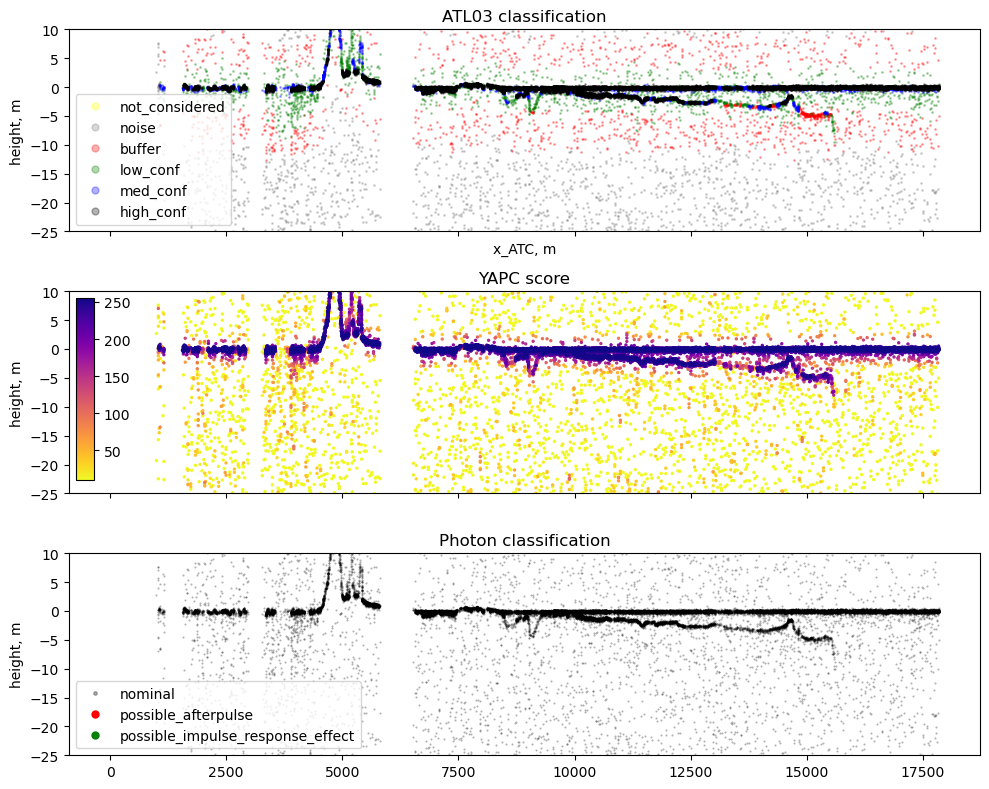

In [21]:
# Create figure and axes
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10, 8), sharex=True)

####################################
# ATL03 signal confidence plot
colors = {-1:['yellow', 'not_considered'],
          0:['grey', 'noise'],  
          1:['red', 'buffer'],
          2:['green','low_conf'],
          3:['blue','med_conf'],
          4:['black', 'high_conf']}

for class_val, color_name in colors.items():
    ii = df['atl03_cnf']==class_val
    axs[0].plot(df['along_track_meters'][ii], df['height_ortho'][ii],
               'o', markersize=1, alpha=0.3, color=color_name[0], 
               label=color_name[1])
               
axs[0].legend(loc=3, frameon=True, markerscale=5)
axs[0].set_xlabel('x_ATC, m')
axs[0].set_ylabel('height, m')  
axs[0].set_title('ATL03 classification')

####################################
# YAPC density based confidence plot
ii = np.argsort(df['yapc_score'])
sc = axs[1].scatter(df['along_track_meters'][ii], df['height_ortho'][ii], 
               2, c=df['yapc_score'][ii], vmin=10, vmax=255, cmap='plasma_r')
axs[1].set_ylim(ylim)
axs[1].set_ylabel('height, m')
axs[1].set_title('YAPC score')

# Add inset axes for colorbar
cax = inset_axes(axs[1], width="2%", height="90%", loc=2)

# Add colorbar to inset axes    
cbar = fig.colorbar(sc, cax=cax, orientation='vertical')  

####################################
# Quality Photon Flag
colors = {0:['black', 'nominal'], 
          1:['red', 'possible_afterpulse'],
          2:['green','possible_impulse_response_effect']}

for class_val, color_name in colors.items():
    ii = df['quality_ph']==class_val
    if class_val==0:
        axs[2].plot(df['along_track_meters'][ii], df['height_ortho'][ii],
                    'o', markersize=.5, alpha=0.3, color=color_name[0], 
                    label=color_name[1])
    else:
        axs[2].plot(df['along_track_meters'][ii], df['height_ortho'][ii],
                    'o', markersize=1, alpha=1, color=color_name[0],
                    label=color_name[1])

axs[2].legend(loc=3, frameon=True, markerscale=5)
axs[2].set_ylabel('height, m')  
axs[2].set_title('Photon classification')

for ax in axs:
    ax.set_ylim(ylim)
    
plt.tight_layout()

We'll use YAPC to filter signal photons for this demo. Specify a manual value by inspection of the data above, or try an automated approach like Otsu Thresholding.

In [22]:
# yapc_threshold = skimage.filters.threshold_otsu(df['yapc_score'])
# plt.hist(df['yapc_score'])
# plt.axvline(yapc_threshold)

yapc_threshold = 25

# Preprocess Data
First, let remove any noise / land photons from the data. Then, let's start to extract water surface and seafloor from the photon data. There are several approaches for this in the literature, but we'll focus on a generalizable, expandable method of histogramming the photon data at a specified resolution.

In [23]:
# get photons with a minimum YAPC signal score 
signal_photons_yapc = df['yapc_score'] > yapc_threshold

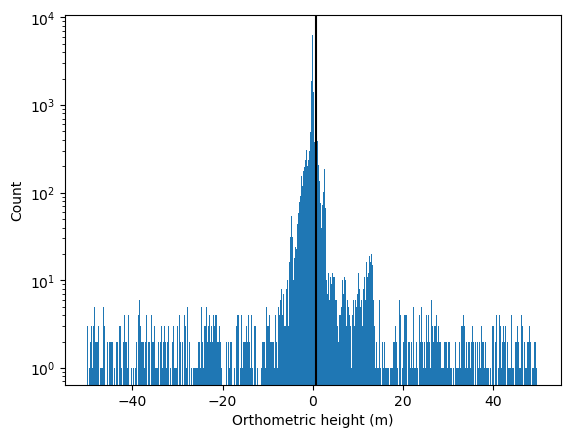

In [24]:
# manually specify a water surface elevation and remove any land photons higher than that
# trim_photons_above = 5 # meters, orthometric height

# alternatively, if your track is mostly water, you can estimate the water surface as the most common photon elevation value
bin_edges_1 = np.arange(-50, 50, 0.1)
hist_1 = plt.hist(df['height_ortho'][signal_photons_yapc], bins=bin_edges_1)[0]

trim_photons_above = bin_edges_1[np.argmax(hist_1)] + 1 # buffer in meters for surface width / waves

plt.axvline(trim_photons_above, color='k')
plt.xlabel('Orthometric height (m)')
plt.ylabel('Count')
plt.yscale('log')

In [25]:
# get dataframe of signal only
water_zone_photons = df['height_ortho'] < trim_photons_above
df_cleaned = df.loc[water_zone_photons & signal_photons_yapc]

In [26]:
res_z = 0.1 # height resolution
res_at = 20 # along track resolution

In [27]:
# define along track bin sizing

bin_edges_z = np.arange(ylim[0], ylim[1], res_z)

range_at = [0, #df_cleaned.along_track_meters.min(), 
            df_cleaned.along_track_meters.max() + res_at]

bin_edges_at = np.arange(range_at[0], range_at[1], res_at)

bin_centers_z = bin_edges_z[:-1] + np.diff(bin_edges_z)[0] / 2

bin_centers_at = bin_edges_at[:-1] + np.diff(bin_edges_at)[0] / 2

hist_2 = np.histogram2d(df_cleaned.along_track_meters, df_cleaned.height_ortho,
               bins = [bin_edges_at, bin_edges_z])[0]

hist_2 = hist_2.T # more intuitive orientation

# using a gaussian filter allows us to use finer binning resolution
sigma_at = 50 / res_at
hist_2 = scipy.ndimage.gaussian_filter1d(hist_2, sigma_at, axis=1)

sigma_z = .2 / res_z
hist_2 = scipy.ndimage.gaussian_filter1d(hist_2, sigma_z, axis=0)


## Inspect Preprocessed Data

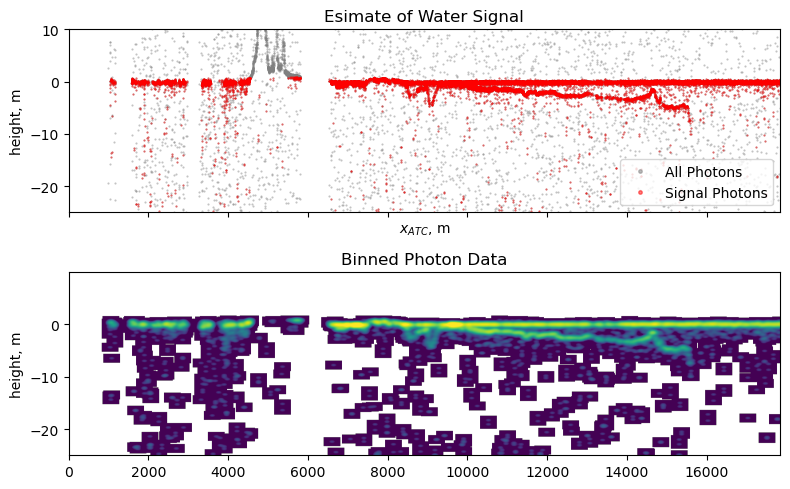

In [28]:
f, ax = plt.subplots(2, 1, figsize=(8, 5), sharex=True)

# plot the photon data
ax[0].plot(df['along_track_meters'],
    df['height_ortho'], '.', c='grey', markersize=1, alpha=0.5, label='All Photons')
ax[0].plot(df_cleaned['along_track_meters'],
    df_cleaned['height_ortho'], 'r.', markersize=1, alpha=0.5, label='Signal Photons')
ax[0].set_ylim(ylim)
ax[0].set_ylabel('height, m')
ax[0].set_xlabel('$x_{ATC}$, m');
ax[0].set_title('Esimate of Water Signal')
ax[0].legend(markerscale=5)

# plot the histogrammed data
orig = ax[1].imshow(hist_2, norm='log',
           vmin=1e-2, vmax=10, # colormap bounds
           cmap='viridis',
           origin='lower',
           interpolation_stage = 'rgba',
           extent=[bin_edges_at[0], bin_edges_at[-1], 
                   bin_edges_z[0], bin_edges_z[-1]], 
           aspect='auto')

ax[1].set_ylabel('height, m')
# f.colorbar(orig, ax=ax[1], label='Count')
ax[1].set_title('Binned Photon Data');

plt.tight_layout()

We'll look at our data in vertical histograms akin to lidar waveforms from other platforms like GEDI. The following cell provides some insight into what this track looks like from this point of view by plotting several points along-track, but it isn't required for the actual analysis. Can you spot the water surface and any seafloor returns in the waveforms?

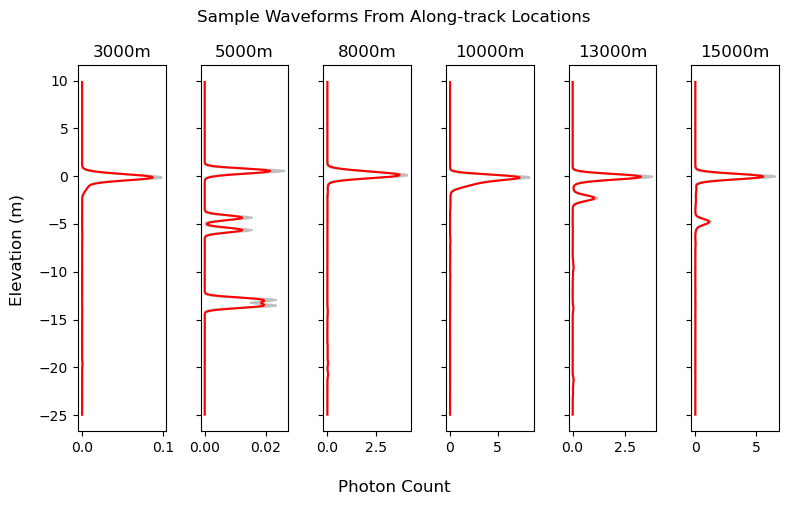

In [29]:

n_inspection_points = 6 # automatically choose equally spaced locations to inspect

inspect_along_track_locations = np.linspace(bin_centers_at[0], bin_centers_at[-1], 
                                            n_inspection_points + 2, # adjust for edges
                                            dtype=np.int64)[1:-1] 

# round 
inspect_along_track_locations = np.round(inspect_along_track_locations, -3)

# inspect_along_track_locations = [5e3] # manually choose locations to inspect

kernel_size_meters = .5

### plotting

kernel_size = np.int64(kernel_size_meters / res_z)

fig, axes = plt.subplots(nrows=1, ncols=len(inspect_along_track_locations), figsize=(8,5), sharey=True)

if len(inspect_along_track_locations) == 1:
    
    axes = [axes]

for i, ax in enumerate(axes):
        
    along_track_location_i = inspect_along_track_locations[i]
    
    waveform = hist_2[:, np.int64(along_track_location_i/res_at)]
    
    waveform_smoothed = np.convolve(waveform, np.ones(kernel_size)/kernel_size, mode='same')

    ax.plot(waveform, bin_centers_z, c='grey', alpha=.5, label='Binned Photon Data')
    
    ax.plot(waveform_smoothed, bin_centers_z, c='r', label='Smoothed Waveform')
    
    ax.set_title(f'{np.int64(along_track_location_i)}m')
    
    # ax.set_xscale('log')


fig.supylabel('Elevation (m)')
fig.supxlabel('Photon Count')
fig.suptitle('Sample Waveforms From Along-track Locations')
plt.tight_layout()

# Refraction Corrected Bathymetry

First, lets create a function for identifying water surface and seafloor returns from the binned data. We find the peaks from each individual waveform, and assume the topmost return is the most likely water surface. From the remaining peaks, we'll select the most prominent peak as bathymetry. We use peak prominence instead of peak heights in order to minimize issues caused by turbidity in the water column. We'll also use height and prominence requirements on the signal peaks specifically tuned for the preprocessing steps defined above.

In [30]:
def extract_bathymetry(waveform, min_height=.25, min_prominence=.25):
    """
    Extracts bathymetry information from a histogram of photon heights and simple assumptions of topographic features.

    Parameters:
    waveform (1D array-like): Input histogram of photon heights.
    min_height (float, optional): Minimum height of peaks to be considered for bathymetry or water surface.
                                  Defaults to 0.25.
    min_prominence (float, optional): Minimum prominence of peaks to be considered for bathymetry or water surface.
                                      Defaults to 0.25.

    Returns:
    water_surface_peak (int or None): Index of the peak representing the water surface, or None if no valid peaks are found.
    bathy_peak (int or None): Index of the peak representing the subsurface bathymetry, or None if no valid peaks are found.

    Notes:
    Input data should be preprocessed to remove as much background noise, land, or vegetation returns as possible.
    
    Author: Jonathan Markel, UT Austin
    Date: 08/2023

    """    
    peaks, peak_info_dict = scipy.signal.find_peaks(waveform, 
                          height=min_height, 
                          prominence=min_prominence)
        
    if len(peaks) == 0:
        return None, None
    
    # topmost return is the water surface
    water_surface_peak = peaks[-1]
    
    # all other peaks are possible bathymetry
    bathy_candidate_peaks = peaks[:-1]
    
    bathy_candidate_peak_heights = peak_info_dict['peak_heights'][:-1]
    bathy_candidate_peak_prominences = peak_info_dict['prominences'][:-1]
    
    if len(bathy_candidate_peaks) == 0:
        return water_surface_peak, None
        
    # get the most prominent subsurface peak
    bathy_peak = bathy_candidate_peaks[np.argmax(bathy_candidate_peak_prominences)]
    
    return water_surface_peak, bathy_peak
    

surface_idx, bathy_idx = extract_bathymetry(waveform_smoothed)


We'll also define a refraction correction function to account for speed of light difference between air and water, as well as the satellite pointing angle. This function is derived from the Parrish, et al. 2019 paper, [Validation of ICESat-2 ATLAS Bathymetry and Analysis of ATLAS’s Bathymetric Mapping Performance](https://www.mdpi.com/2072-4292/11/14/1634). A Matlab implementation is also available [here](https://github.com/ICESat2-Bathymetry/Information/tree/main/code).

In [31]:
def photon_refraction(W, Z, ref_az, ref_el,
                      n1=1.00029, n2=1.34116):
    '''
    ICESat-2 refraction correction implemented as outlined in Parrish, et al. 
    2019 for correcting photon depth data.

    Highly recommended to reference elevations to geoid datum to remove sea
    surface variations.

    https://www.mdpi.com/2072-4292/11/14/1634

    Author: 
    Jonathan Markel
    Graduate Research Assistant
    3D Geospatial Laboratory
    The University of Texas at Austin
    jonathanmarkel@gmail.com

    Parameters
    ----------
    W : float, or nx1 array of float
        Elevation of the water surface.

    Z : nx1 array of float
        Elevation of seabed photon data. Highly recommend use of geoid heights.

    ref_az : nx1 array of float
        Photon-rate reference photon azimuth data. Should be pulled from ATL03
        data parameter 'ref_azimuth'. Must be same size as seabed Z array.

    ref_el : nx1 array of float
        Photon-rate reference photon azimuth data. Should be pulled from ATL03
        data parameter 'ref_elev'. Must be same size as seabed Z array.

    n1 : float, optional
        Refractive index of air. The default is 1.00029.

    n2 : float, optional
        Refractive index of water. Recommended to use 1.34116 for saltwater 
        and 1.33469 for freshwater. The default is 1.34116.

    Returns
    -------
    dE : nx1 array of float
        Easting offset of seabed photons.

    dN : nx1 array of float
        Northing offset of seabed photons.

    dZ : nx1 array of float
        Vertical offset of seabed photons.

    '''

    # compute uncorrected depths
    D = W - Z
    H = 496  # mean orbital altitude of IS2, km
    Re = 6371  # mean radius of Earth, km

    # angle of incidence (wout Earth curvature)
    theta_1_ = (np.pi / 2) - ref_el

    # # ignoring curvature correction based on correspondence with the author
    # # incidence correction for earths curvature - eq 13
    # delta_theta_EC = np.arctan(H * np.tan(theta_1_) / Re)

    # angle of incidence
    theta_1 = theta_1_ # + delta_theta_EC

    # angle of refraction
    theta_2 = np.arcsin(n1 * np.sin(theta_1) / n2)  # eq 1

    phi = theta_1 - theta_2

    # uncorrected slant range to the uncorrected seabed photon location
    S = D / np.cos(theta_1)  # eq 3

    # corrected slant range
    R = S * n1 / n2  # eq 2

    P = np.sqrt(R**2 + S**2 - 2*R*S*np.cos(theta_1 - theta_2))  # eq 6

    gamma = (np.pi / 2) - theta_1  # eq 4

    alpha = np.arcsin(R * np.sin(phi) / P)  # eq 5

    beta = gamma - alpha  # eq 7

    # cross-track offset
    dY = P * np.cos(beta)  # eq 8

    # vertical offset
    dZ = P * np.sin(beta)  # eq 9

    kappa = ref_az

    # UTM offsets
    dE = dY * np.sin(kappa)  # eq 10
    dN = dY * np.cos(kappa)  # eq 11

    return dE, dN, dZ

Finally, we'll loop through each waveform, extract surfaces, compute refraction corrections, and store the resulting data.

In [32]:
# set up storage for binned and photon bathymetry data
water_surface = np.nan * np.ones_like(bin_centers_at) # elevation, EGM08
bathymetry_uncorrected = np.nan * np.ones_like(bin_centers_at)
bathymetry_corrected = np.nan * np.ones_like(bin_centers_at)
bin_centroid = np.empty_like(bin_centers_at, dtype=shapely.Point) # location of bin in lat / lon
df_cleaned['dz_refraction'] = 0 # refraction correction

# for each location along track (with a progress bar)
for i_at in tqdm(range(len(bin_centers_at))):
    
    waveform_i = hist_2[:, i_at]
        
    # 1. ESTIMATE WATER/SEAFLOOR SURFACES
    surface_idx, bathy_idx = extract_bathymetry(waveform_i, 
                                                min_height=0.1, 
                                                min_prominence=0.1)

    if surface_idx is None:
        continue 
        
    # get the actual elevation
    water_surface_z = bin_centers_z[surface_idx]
    water_surface[i_at] = water_surface_z
            
    # 2. REFRACTION CORRECT PHOTON HEIGHTS
            
    # index subsurface photons in this along-track bin
    ph_refr_i = (df_cleaned.along_track_meters.values >= bin_centers_at[i_at] - res_at / 2) & \
                (df_cleaned.along_track_meters.values <= bin_centers_at[i_at] + res_at / 2) & \
                (df_cleaned.height_ortho.values <= (water_surface_z))
    
    # no photons in this bin
    if np.sum(ph_refr_i) == 0:
        continue
    
    z_ph_i = df_cleaned.height_ortho.values[ph_refr_i]
    ref_az_ph_i = df_cleaned.ref_azimuth.values[ph_refr_i]
    ref_elev_ph_i = df_cleaned.ref_elev.values[ph_refr_i]
    
    # compute refraction corrections for all subsurface photons
    _, _, dz_ph_i = photon_refraction(water_surface_z, 
                                   z_ph_i, ref_az_ph_i, ref_elev_ph_i, 
                                   n1=1.00029, n2=1.34116)
    
    df_cleaned.loc[ph_refr_i, 'dz_refraction'] = dz_ph_i
    
    # compute refraction correction for modeled bathymetry return
    if bathy_idx is None:
        continue        
        
    bathymetry_uncorrected_i = bin_centers_z[bathy_idx]
                        
    ref_az_bin_i = np.mean(ref_az_ph_i)
    ref_elev_bin_i = np.mean(ref_elev_ph_i)
    _, _, dz_bin_i = photon_refraction(water_surface_z, 
                               bathymetry_uncorrected_i, 
                                       ref_az_bin_i, ref_elev_bin_i, 
                               n1=1.00029, n2=1.34116)
    
    bathymetry_corrected_i = bathymetry_uncorrected_i + dz_bin_i
    
    # filter likely erroneous signal caused by wave / turbidity 
    
    if (water_surface_z - bathymetry_corrected_i) < min_bathy_depth:
        continue
        
    elif (water_surface_z - bathymetry_corrected_i) > max_bathy_depth:
        continue

    bathymetry_uncorrected[i_at] = bathymetry_uncorrected_i
    bathymetry_corrected[i_at] = bathymetry_corrected_i
    
    # geolocate this bin
    bin_centroid[i_at] = df_cleaned.loc[ph_refr_i, 'geometry'].unary_union.centroid

/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
  0%|          | 0/892 [00:00<?, ?it/s]/tmp/ipykernel_714/2851525998.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[8.48232  8.359198]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_cleaned.loc[ph_refr_i, 'dz_refraction'] = dz_ph_i
/tmp/ipykernel_714/2851525998.py:74: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  bin_centroid[i_at] = df_cleaned.loc[ph_refr_i, 'geometry'].unary_union.centroid
/tmp

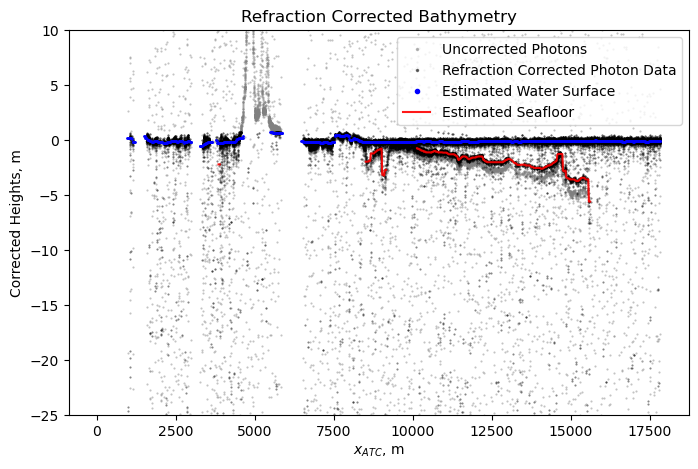

In [33]:
f = plt.figure(figsize=(8, 5))

# # unrefracted photon elevations
plt.plot(df.along_track_meters, df.height_ortho, '.',
        c='grey', markersize=1, alpha=0.5, label='Uncorrected Photons')

plt.plot(df_cleaned.along_track_meters, df_cleaned.height_ortho + df_cleaned.dz_refraction, 'k.',
        markersize=1, alpha=0.5, label='Refraction Corrected Photon Data')

plt.plot(bin_centers_at, water_surface, 'b.', 
         markersize=2, alpha=1, label='Estimated Water Surface')

plt.plot(bin_centers_at, bathymetry_corrected, 'r-', 
          markersize=1, alpha=0.9, label='Estimated Seafloor')



plt.ylabel('Corrected Heights, m')
plt.xlabel('$x_{ATC}$, m');
plt.ylim(ylim)
plt.title('Refraction Corrected Bathymetry');
plt.legend(markerscale=3)
plt.show()

# Postprocessing

Let's organize our bathymetry data into a GeoDataFrame for visualization and exporting to other tools.

In [34]:
good_data = ~np.isnan(bathymetry_corrected)

df_out = gpd.GeoDataFrame(np.vstack([water_surface[good_data], 
                                     bathymetry_corrected[good_data]]).T, 
                 columns=['water_surface_z', 'bathymetry_corr_z'], 
                 geometry=bin_centroid[good_data], 
                 crs=df_cleaned.crs)

df_out['depth'] = df_out.water_surface_z - df_out.bathymetry_corr_z

df_out.head()


,water_surface_z,bathymetry_corr_z,geometry,depth
0,-0.25,-2.189268,POINT (172.87795 -40.50462),1.939268
1,-0.25,-2.189268,POINT (172.87793 -40.50473),1.939268
2,-0.25,-2.189268,POINT (172.8779 -40.50496),1.939268
3,0.15,-1.341745,POINT (172.87728 -40.50995),1.491745
4,-0.15,-1.940093,POINT (172.87263 -40.54637),1.790093


In [35]:
# inspect data on an interactive map
plot_color_depth = df_out.depth.quantile(0.99) # percentile defines maximum depth for colormap

# sort for better color visibility when plotting
df_vis = df_out.sort_values('bathymetry_corr_z', ascending=False)

df_vis.explore(tiles='Esri.WorldImagery', 
                 column='depth', 
                 cmap='inferno_r', 
                 vmax=plot_color_depth,        # minimum depth for plotting color
                 vmin=min_bathy_depth)


Now that our data is organized as a GeoDataFrame, we can utilize any of the many built in tools for saving to different filetypes. [For more, see GeoPandas documentation here](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.to_file.html).

Congrats! You're now able to compute refraction corrected bathymetry from ICESat-2 photon data!


# Helpful Links

- [ICESat-2 Bathymetry Working Group Information Repository](https://github.com/ICESat2-Bathymetry/Information)
- [C-SHELPH Bathymetric Photon Classification - Github](https://github.com/nmt28/C-SHELPh)

# Contact Information
Get in touch!

**Jonathan Markel**<br>
PhD Student<br>
3D Geospatial Laboratory<br>
The University of Texas at Austin<br>
jonathanmarkel@gmail.com<br>